# tap-suite
A Suite and Generator of Tunnel Alignment Problems.

### 1. Optimizing the problems from the suite: 

In [1]:
from tap import get_tap_suite

#### 1.A  Run suite problems with Pymoo

In [2]:
# get the list of 12 problems from the suite, wrapped in a class that support optimization with pymoo library
suite = get_tap_suite(interface="pymoo") 
# pick one problem to optimize
problem = suite[3]
problem.name, problem.id

('TAP4', '15-areas_hor=1_ver=2_CV')

In [3]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination

# optimize selected problem with NSGA2 algorithm
algorithm = NSGA2(pop_size=100)
termination = get_termination("n_eval", 500)
results = minimize(problem, algorithm, termination, verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      4 |  0.000000E+00 |  3.6479353710 |             - |             -
     2 |      200 |      7 |  0.000000E+00 |  0.0591441885 |  0.0242239185 |         ideal
     3 |      300 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0183878428 |         ideal
     4 |      400 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0724697403 |         ideal
     5 |      500 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0973167994 |         ideal


In [4]:
# problems from the suite already have approximations for ideal and nadir points set
problem.ideal, problem.nadir

([0, 0], [0.3018191170221708, 0.0003757249154668])

#### 1.B Run suite problems with jMetalPy

In [5]:
from jmetal.algorithm.multiobjective.nsgaii import NSGAII
from jmetal.operator.crossover import SBXCrossover
from jmetal.operator.mutation import PolynomialMutation
from jmetal.util.termination_criterion import StoppingByEvaluations

# get the list of 12 problems from the suite, wrapped in a class that support optimization with jmetalpy library
suite = get_tap_suite(interface="jmetalpy")
problem = suite[3]

# optimize selected problem with NSGA2 algorithm
algorithm = NSGAII(
    problem=problem,
    population_size=100,
    offspring_population_size=100,
    mutation=PolynomialMutation(probability=1.0 / problem.number_of_variables(), distribution_index=20),
    crossover=SBXCrossover(probability=1.0, distribution_index=20),
    termination_criterion=StoppingByEvaluations(max_evaluations=500)
)
algorithm.run()

[2025-05-22 11:07:32,827] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-05-22 11:07:32,829] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-05-22 11:07:36,332] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-05-22 11:07:36,333] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2025-05-22 11:07:48,901] [jmetal.core.algorithm] [DEBUG] Finished!


#### 1.C Run suite problems with other library/custom algorithm


In [6]:
# create a custom interface that wraps the problems from the suite and defines the required methods (if needed)
class CustomProblem:
    def __init__(self, problem):
        self.problem = problem
        self.id = problem.id
        self.name = problem.name
        self.ideal = problem.ideal
        self.nadir = problem.nadir
        # ...

    def evaluate(self, x):
        constraints, objectives = self.problem.evaluate(x)
        return constraints, objectives
    
    # ...

In [7]:
# get the suite of 12 problems and wrap them with the defined class
suite = get_tap_suite()
custom_suite = [CustomProblem(p) for p in suite]

### 2. Generating Problems

In [8]:
# Problem is represented as a python dictionary
problem = {}

Set the problem id and geometric constraints

In [9]:
problem["problem_id"] = "demo_problem"

problem["max_horizontal_turns"] = 2
problem["max_vertical_turns"] = 2
problem["basic_material_cost"] = 1
problem["max_gradient"] = 0.05

Set the area of the problem, determined with limits and obstacles

In [10]:
limits = {    
    "x": [0, 3000],
    "y": [0, 1000],
    "z": [0, 100]
}

obstacles = [
    {
        "type": "circle",
        "center": [1000, 800],
        "r": 200,
        "price": 10
    },
    {
        "type": "sphere",
        "center": [2700, 450, 50],
        "r": 50,
        "price": 10
    },
    {
        "type": "polygon", 
        "points": [
            [1500, 700],
            [1900, 400],
            [1700, 400],
            [1700, 0],
            [1300, 0],
            [1300, 400],
            [1100, 400]
        ],
        "z": [10, 100]
        # no price defined -> infeasible obstacle
    }
]

problem["bounds"] = {
    "limits": limits,
    "obstacles": obstacles
}

Set the positions of start, end and given points

In [11]:
start_point = {
    "x": 100,
    "y": 500,
    "z": 50,
    "r_max": 30,
    "h_angle": 0,
    "h_angle_tol": 45,
    "v_angle": 0,
    "v_angle_tol": 5
}
end_point = {
    "x": 2900,
    "y": 500,
    "z": 50,
    "r_max": 30,
    "h_angle": -180,
    "h_angle_tol": 45,
    "v_angle": -180,
    "v_angle_tol": 5
}
given_points = [{
    "x": 2500,
    "y": 400,
    "z": 50,
    "r_max": 50,
    "h_angle": 0,
    "h_angle_tol": 180,
    "v_angle": 0,
    "v_angle_tol": 5,
    "order": 0.5
}]

problem["points"] = {
    "start_point": start_point,
    "end_point": end_point,
    "given_points": given_points,
    "free_points_threshold": 0.25  
}

Set the objectives, constraints and evaluation tree (best to leave it as is)

In [12]:
problem["objectives"] = ["costs", "effects"]

problem["constraints"] = ["horizontal_curvature", "vertical_curvature", "gradient",
                          "point_distance_deviation",
                          "point_horizontal_angle_deviation", "point_vertical_angle_deviation"]

problem["hard_constraints"] = ["out_of_bound_points", "hard_constraint_obstacles",
                               "horizontal_turns", "vertical_turns", "self_intersections"]

problem["evaluation_tree"] = {
    "weight": 1,
    "direction": "min",
    "norm_min": 0,
    "norm_max": 1,
    "inputs": {
        "costs": {
            "weight": 0.5,
            "direction": "min",
            "norm_min": 0,
            "norm_max": 100000
        },
        "effects": {
            "weight": 0.5,
            "direction": "min",
            "bound": 0,
            "norm_min": 0,
            "norm_max": 0.6,
            "inputs": {
                "horizontal_curvature": {
                    "weight": 0.1,
                    "direction": "min",
                    "norm_min": 0,
                    "norm_max": 1,
                    "bound": 0.1
                },
                "vertical_curvature": {
                    "weight": 0.1,
                    "direction": "min",
                    "norm_min": 0,
                    "norm_max": 1,
                    "bound": 0.1
                },
                "gradient": {
                    "weight": 0.1,
                    "direction": "min",
                    "norm_min": 0,
                    "norm_max": 1,
                    "bound": 0.05
                },
                "point_distance_deviation": {
                    "weight": 0.1,
                    "direction": "min",
                    "norm_min": 0,
                    "norm_max": 3000,
                    "bound": 0
                },
                "point_horizontal_angle_deviation": {
                    "weight": 0.1,
                    "direction": "min",
                    "norm_min": 0,
                    "norm_max": 3.141592653589793,
                    "bound": 0
                },
                "point_vertical_angle_deviation": {
                    "weight": 0.1,
                    "direction": "min",
                    "norm_min": 0,
                    "norm_max": 3.141592653589793,
                    "bound": 0
                }
            }
        }
    }
}


Finally, set the ideal and nadir points

In [13]:
problem["ideal"] = [0, 0]
problem["nadir"] = [1, 1]

Visualize the created problem

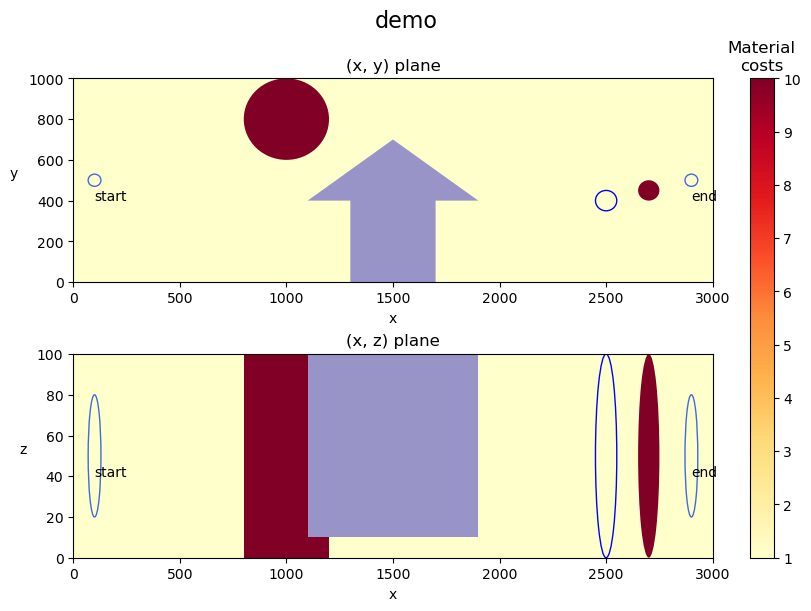

In [14]:
from tap import TunnelAlignmentProblem

tap_problem = TunnelAlignmentProblem(problem, "AFV")
fig = tap_problem.plot_problem()

Wrap the problem into the Pymoo interface class and run optimization

In [15]:
from tap import PymooProblem
pymoo_problem = PymooProblem(tap_problem)

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination

algorithm = NSGA2(pop_size=100)
termination = get_termination("n_eval", 500)
result = minimize(pymoo_problem, algorithm, termination, verbose=True, seed=42)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      2 |  0.000000E+00 |  5.8063661670 |             - |             -
     2 |      200 |      2 |  0.000000E+00 |  4.3548929956 |  0.6746845192 |         ideal
     3 |      300 |      4 |  0.000000E+00 |  2.4933075831 |  0.2100512420 |             f
     4 |      400 |      5 |  0.000000E+00 |  0.0012096046 |  0.2670364128 |         ideal
     5 |      500 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0457576420 |             f


Plot the problem with the results

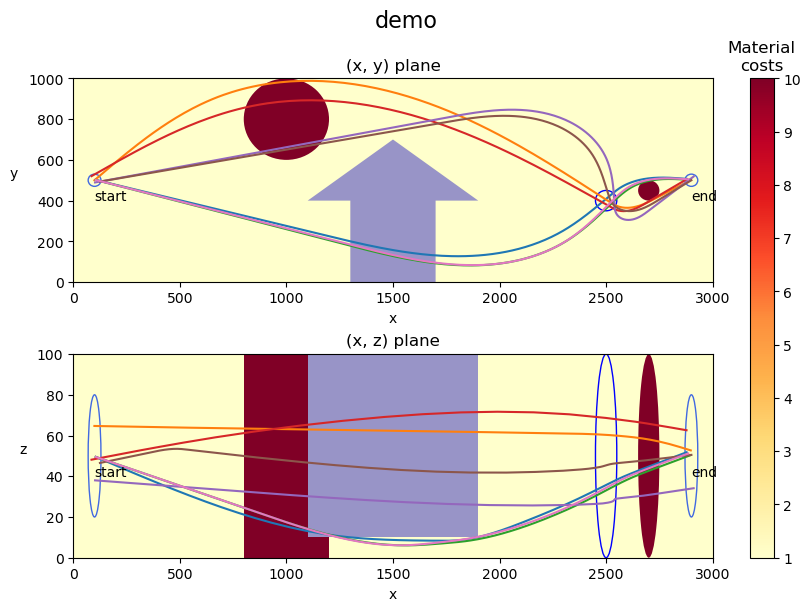

In [16]:
non_dominated_results = result.X
fig2 = tap_problem.plot_problem(non_dominated_results)